In [1]:
using JuMP
using Gurobi
using CSV
using DataFrames
using Plots

const GRB_ENV = Gurobi.Env(output_flag=1);
set_optimizer_attribute(model, "NumericFocus", 3)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-21


In [14]:
facilities = CSV.read("Demand.csv",DataFrame);
food_prices = CSV.read("Food_Prices.csv",DataFrame);
warehouses = CSV.read("Warehouses.csv",DataFrame);
transportation = CSV.read("Transportation_costs.csv",DataFrame) |> Matrix;
nutritional_value = CSV.read("Nutritional_Value.csv",DataFrame) |> Matrix;
nutrients = CSV.read("Nutrients.csv",DataFrame);

# Extract data from DataFrames into arrays for easier indexing
D = facilities[!, :Population] |> Array; # demand for each facility location j (vector, 27)
D = D[1:end, 1:end] * 0.01; # fraction of population for now that makes solution feasible
t = transportation[1:end, 1:end .!= 1]; # removing extra column from transportation costs (matrix, 10 x 27)
π = food_prices[!, :PriceFINAL] |> Array; # food prices per item k (vector, 14)
V = parse.(Float64,string.(nutritional_value[1:end, 1:end .!= 1])) .* 10 |> Array; # nutritional value for the different types of foods (matrix, 14 x 5)
N = nutrients[!, :Requirements] |> Array; # daily requirements for select nutrients (vector, 5)
C = 1000000000000 # max capacity constraint
S = 10000 # cost to build a facility

# variable index sizes
m = size(t)[1]; # number of warehouses, 10
n = size(t)[2]; # number of facilities (demand), 27
p = size(π)[1]; # number of food items, 14
q = size(N)[1]; # number of nutrient requirements, q

## Model formulation without uncertainty (nominal value of transportation costs)

Set parameter Method to value 0
Set parameter NumericFocus to value 3
Set parameter Method to value 0
Set parameter NumericFocus to value 3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads
Optimize a model with 762 rows, 3807 columns and 7965 nonzeros
Model fingerprint: 0xe9f5142a
Variable types: 3780 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+12]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2534814.1195
Presolve removed 762 rows and 3807 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 11 available processors)

Solution count 2: 383035 2.53481e+06 

Optimal solution found (tolerance 1.00e-04)
         (possibly due to large matrix coefficie

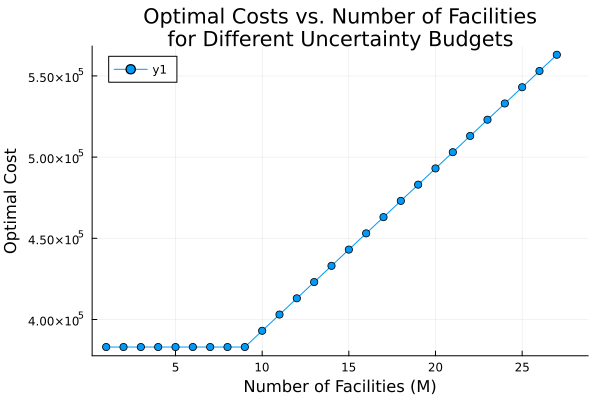

In [40]:
function nominal_model(M)

    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attribute(model, "Method", 0)

    # Variables
    @variable(model, y[1:n], Bin)                 # facility decisions
    @variable(model, x[1:m, 1:n, 1:p] >= 0)      # transportation quantities

    # objective
    @objective(model, Min, 
    sum(π[k] * x[i, j, k] for i in 1:m, j in 1:n, k in 1:p) +
    sum(t[i, j] * x[i, j, k] for i in 1:m, j in 1:n, k in 1:p) +
    S * sum(y[j] for j in 1:n))

    # Constraints
    @constraint(model, [j=1:n, k=1:p], sum(x[i, j, k] for i in 1:m) >= D[j]) # meet all demands for each population j
    @constraint(model, [l=1:q], sum(V[k, l] for k in 1:p) >= N[l]) # meet daily nutrient requirements
    @constraint(model, [k=1:p, j=1:n], sum(x[i, j, k] for i in 1:m) <= C * y[j]) # do not exceed facility capacity, IGNORE
    @constraint(model, sum(y[j] for j in 1:n) >= M) # must build at least M facilities

    set_optimizer_attribute(model, "NumericFocus", 3)

    # Solve
    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        println("Optimal total cost: ", objective_value(model))
        selected_facilities = findall(value.(y) .> 0.5)  # Indices of nonzero y
        println("Selected facilities (indices): ", selected_facilities)
        return objective_value(model)
    else
        println("No optimal solution found.")
        return NaN
    end
end

function plot_comparison()
    M_values = 1:28
    
    # Initialize plot
    p = plot(
        xlabel="Number of Facilities (M)",
        ylabel="Optimal Cost",
        title="Optimal Costs vs. Number of Facilities\nfor Different Uncertainty Budgets",
        legend=:topleft
    )
    
        costs = [nominal_model(M) for M in M_values]
        plot!(p, M_values, costs, 
            # label="Γ = $Γ",
            marker=:circle,
            markersize=4)
    
    return p
end

# Generate the comparison plot
plot_comparison()

In [41]:
M = 9
nominal_model(M)

Set parameter Method to value 0
Set parameter NumericFocus to value 3
Set parameter Method to value 0
Set parameter NumericFocus to value 3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads
Optimize a model with 762 rows, 3807 columns and 7965 nonzeros
Model fingerprint: 0xa122628b
Variable types: 3780 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+12]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 2e+04]
Found heuristic solution: objective 2534814.1195
Presolve removed 762 rows and 3807 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 11 available processors)

Solution count 2: 383035 2.53481e+06 

Optimal solution found (tolerance 1.00e-04)
         (possibly due to large matrix coefficie

383034.9090967625

## Results for nominal value model

M = 1:
Optimal total cost: 383034.9090967625
Selected facilities (indices): [3, 5, 10, 11, 12, 13, 14, 15, 16]

M = 10:
Optimal total cost: 393034.9090967625
Selected facilities (indices): [3, 5, 10, 11, 12, 13, 14, 15, 16, 27]

M = 15:
Optimal total cost: 443034.9090967625
Selected facilities (indices): [3, 5, 10, 11, 12, 13, 14, 15, 16, 22, 23, 24, 25, 26, 27]

M = 20:
Optimal total cost: 493034.9090967625
Selected facilities (indices): [3, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

M = 24:
Optimal total cost: 533034.9090967625
Selected facilities (indices): [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

M = 27:
Optimal total cost: 563034.9090967625
Selected facilities (indices): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


## Model formulation without uncertainty (nominal value of transportation costs)

Set parameter Method to value 0
Set parameter Method to value 0
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads
Optimize a model with 1572 rows, 4077 columns and 19845 nonzeros
Model fingerprint: 0x20282bd4
Variable types: 4050 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+12]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2534814.1195
Presolve removed 1572 rows and 4077 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 11 available processors)

Solution count 2: 383035 2.53481e+06 

Optimal solution found (tolerance 1.00e-04)
         (pos

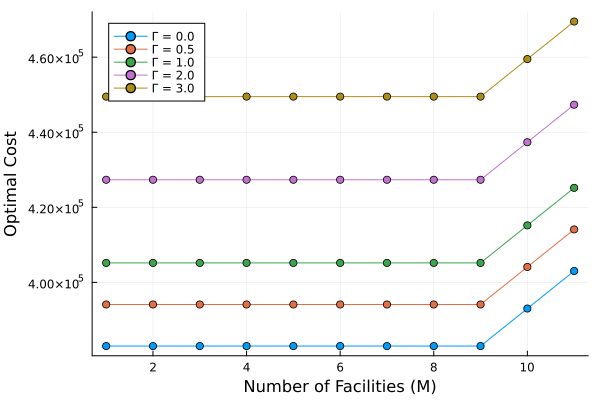

xplored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 1 (of 11 available processors)

Solution count 2: 449492 1.62e+12 

Optimal solution found (tolerance 1.00e-04)
         (possibly due to large matrix coefficients)
Best objective 4.494917898890e+05, best bound 4.494917898890e+05, gap 0.0000%

User-callback calls 265, time in user-callback 0.00 sec
Set parameter Method to value 0
Set parameter Method to value 0
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads
Optimize a model with 1572 rows, 4077 columns and 20115 nonzeros
Model fingerprint: 0x0f8e24f4
Variable types: 4050 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+12]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid n

In [45]:
function makeDelta(t̄)
    Δ = (1.5 .- 0.7) .* t̄
    return Δ
end


function robustModel(M, Γ)
    t̄ = t # updating variable in sync with robust formulation

    # Calculate deviation matrix
    Δ = makeDelta(t̄)

    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attribute(model, "Method", 0)

    # Variables
    @variable(model, y[1:n], Bin)                 # facility decisions
    @variable(model, x[1:m, 1:n, 1:p] >= 0)      # transportation quantities
    @variable(model, z[1:m, 1:n] >= 0)           # robust optimization variables

    # Objective: minimize total cost with robust transportation costs
    @objective(model, Min,
        sum(π[k] * x[i,j,k] for i in 1:m, j in 1:n, k in 1:p) +
        sum(t̄[i,j] * sum(x[i,j,k] for k in 1:p) + Γ * z[i,j] for i in 1:m, j in 1:n) +
        S * sum(y[j] for j in 1:n)
    )

    # Original constraints
    @constraint(model, [j=1:n, k=1:p], 
        sum(x[i,j,k] for i in 1:m) >= D[j])
    @constraint(model, [l=1:q], 
        sum(V[k,l] for k in 1:p) >= N[l])
    @constraint(model, [k=1:p, j=1:n], 
        sum(x[i,j,k] for i in 1:m) <= C * y[j])
    @constraint(model, 
        sum(y[j] for j in 1:n) >= M)

    # Robust optimization constraints
    @constraint(model, [i=1:m, j=1:n], sum(t[i, j] * x[i, j, k] for k in 1:p) + Γ * z[i, j] >= 0)
    @constraint(model, [i=1:m, j=1:n],
        z[i,j] >= Δ[i,j] * sum(x[i,j,k] for k in 1:p))
    @constraint(model, [i=1:m, j=1:n],
        z[i,j] >= -Δ[i,j] * sum(x[i,j,k] for k in 1:p))

    # Solve
    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        return objective_value(model)
    else
        return NaN
    end
end

function plot_comparison()
    M_values = 1:11
    Γ_values = [0, 0.5, 1, 2, 3]
    
    # Initialize plot
    p = plot(
        xlabel="Number of Facilities (M)",
        ylabel="Optimal Cost",
        # title="Optimal Costs vs. Number of Facilities\nfor Different Uncertainty Budgets",
        legend=:topleft
    )
    
    # Calculate and plot for each Γ
    for Γ in Γ_values
        costs = [robustModel(M, Γ) for M in M_values]
        plot!(p, M_values, costs, 
            label="Γ = $Γ",
            marker=:circle,
            markersize=4)
    end
    
    return p
end

# Generate the comparison plot
plot_comparison()

Set parameter Method to value 0
Set parameter Method to value 0
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads
Optimize a model with 1302 rows, 4077 columns and 16065 nonzeros
Model fingerprint: 0x6bc14c2a
Variable types: 4050 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+12]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2534814.1195
Presolve removed 1302 rows and 4077 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 11 available processors)

Solution count 2: 383035 2.53481e+06 

Optimal solution found (tolerance 1.00e-04)
         (pos

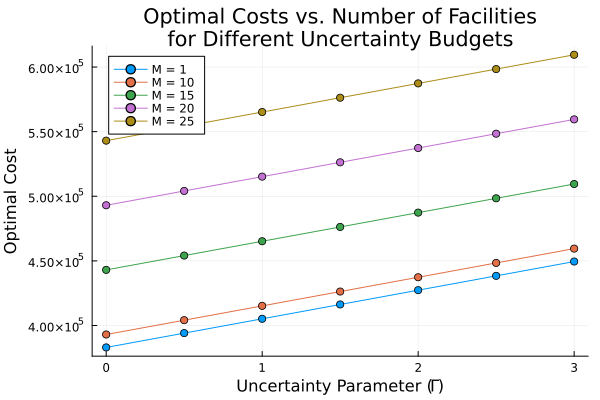

In [34]:
function makeDelta(t̄)
    Δ = (1.5 .- 0.7) .* t̄
    return Δ
end


function robustModel(M, Γ)
    # Read and prepare data
    facilities = CSV.read("Demand.csv", DataFrame)
    food_prices = CSV.read("Food_Prices.csv", DataFrame)
    warehouses = CSV.read("Warehouses.csv", DataFrame)
    transportation = CSV.read("Transportation_costs.csv", DataFrame) |> Matrix
    nutritional_value = CSV.read("Nutritional_Value.csv", DataFrame) |> Matrix
    nutrients = CSV.read("Nutrients.csv", DataFrame)

    # Extract data
    # D = facilities[!, :Population] |> Array
    # D = D[1:end, 1:end] * 0.01
    t̄ = transportation[1:end, 1:end .!= 1]  # nominal transportation costs
    # π = food_prices[!, :PriceFINAL] |> Array
    # V = parse.(Float64, string.(nutritional_value[1:end, 1:end .!= 1])) .* 10 |> Array
    # N = nutrients[!, :Requirements] |> Array

    # Calculate deviation matrix
    Δ = makeDelta(t̄)

    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attribute(model, "Method", 0)

    # Variables
    @variable(model, y[1:n], Bin)                 # facility decisions
    @variable(model, x[1:m, 1:n, 1:p] >= 0)      # transportation quantities
    @variable(model, z[1:m, 1:n] >= 0)           # robust optimization variables

    # Objective: minimize total cost with robust transportation costs
    @objective(model, Min,
        sum(π[k] * x[i,j,k] for i in 1:m, j in 1:n, k in 1:p) +
        sum(t̄[i,j] * sum(x[i,j,k] for k in 1:p) + Γ * z[i,j] for i in 1:m, j in 1:n) +
        S * sum(y[j] for j in 1:n)
    )

    # Original constraints
    @constraint(model, [j=1:n, k=1:p], 
        sum(x[i,j,k] for i in 1:m) >= D[j])
    @constraint(model, [l=1:q], 
        sum(V[k,l] for k in 1:p) >= N[l])
    @constraint(model, [k=1:p, j=1:n], 
        sum(x[i,j,k] for i in 1:m) <= C * y[j])
    @constraint(model, 
        sum(y[j] for j in 1:n) >= M)

    # Robust optimization constraints
    # @constraint(model, [i=1:m, j=1:n], sum(t[i, j] * x[i, j, k] for k in 1:p) + Γ * z[i, j] >= 0)
    @constraint(model, [i=1:m, j=1:n],
        z[i,j] >= Δ[i,j] * sum(x[i,j,k] for k in 1:p))
    @constraint(model, [i=1:m, j=1:n],
        z[i,j] >= -Δ[i,j] * sum(x[i,j,k] for k in 1:p))

    # Solve
    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        return objective_value(model)
    else
        return NaN
    end
end

function plot_comparison()
    M_values = [1,10,15,20,25]
    Γ_values = [0, 0.5, 1, 1.5, 2, 2.5, 3]
    
    # Initialize plot
    p = plot(
        xlabel="Uncertainty Parameter (\\Gamma)",
        ylabel="Optimal Cost",
        title="Optimal Costs vs. Number of Facilities\nfor Different Uncertainty Budgets",
        legend=:topleft
    )
    
    # Calculate and plot for each Γ
    for M in M_values
        costs = [robustModel(M, Γ) for Γ in Γ_values]
        plot!(p, Γ_values, costs, 
            label="M = $M",
            marker=:circle,
            markersize=4)
    end
    
    return p
end

# Generate the comparison plot
plot_comparison()